# MP 1
### Emmanuel Gallegos
### CS 543: Computer Vision
### Prof. Svetlana Lazebnik
### University of Illinois Urbana Champaign

In [23]:
import time
import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [24]:
# useful constants
UP=0
RIGHT=1
DOWN=2
LEFT=3
BLUE=0
GREEN=1
RED=2

In [28]:
# roll a 2d image in a given direction (0->up, 1->right, 2->down, 3->left)
def roll_image(image, direction, n_pixels):
    if direction == UP:
        return np.roll(image, -n_pixels, axis=1)
    elif direction == DOWN:
        return np.roll(image, n_pixels, axis=1)
    elif direction == RIGHT:
        return np.roll(image, n_pixels, axis=0)
    elif direction == LEFT:
        return np.roll(image, -n_pixels, axis=0)

In [26]:
# set image paths
basic_img_dir = os.path.join(os.getcwd(), "data")
hires_img_dir = os.path.join(os.getcwd(), "data_hires")
basic_img_paths = [os.path.join(basic_img_dir, img_path) for img_path in os.listdir(basic_img_dir)]
print(basic_img_paths)

['C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\00125v.jpg', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\00149v.jpg', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\00153v.jpg', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\00351v.jpg', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\00398v.jpg', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\01112v.jpg']


best blue displacement: (-8, 1)
best red displacement: (1, -1)


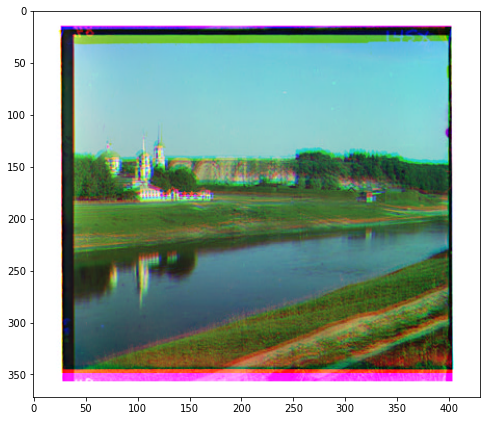

best blue displacement: (-5, -1)
best red displacement: (6, 0)


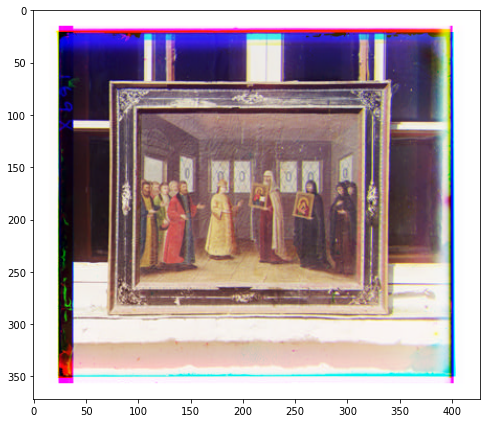

best blue displacement: (-2, -2)
best red displacement: (12, 2)


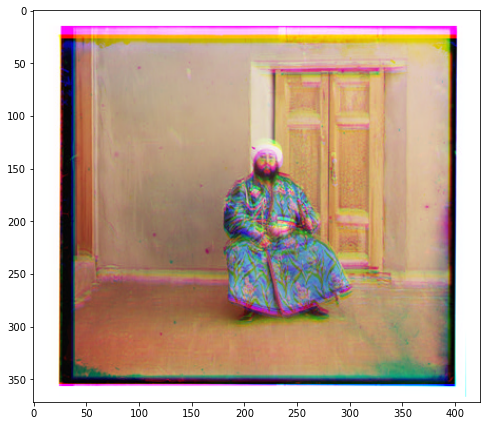

best blue displacement: (-5, 0)
best red displacement: (10, 0)


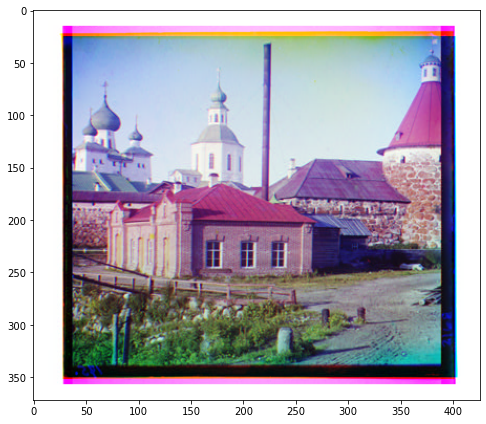

best blue displacement: (-7, 1)
best red displacement: (7, -1)


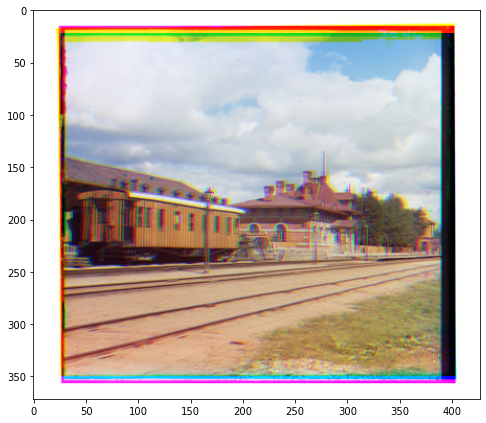

In [ ]:
for img_path in basic_img_paths: 
    # open image
    image = Image.open(img_path)
    grayscale_img = image.convert("L")
    # image to numpy array
    np_img = np.array(image)
    # ensure n_rows is multiple of 3
    while np_img.shape[0] % 3 != 0:
        np_img = np.pad(np_img, ((0,1),(0,0)), mode='constant', constant_values=255)
    # get 3 channel images
    bgr_channels = np.array(np.array_split(np_img, 3))
    # pad the images with 15 rows/cols of 255
    padded_channels = np.pad(bgr_channels,((0,0),(15,15),(15,15)), mode='constant', constant_values=255)
    # save shape of channel
    original_shape = padded_channels.shape
    # unroll the channels to 1d arrays
    unrolled_channels = padded_channels.reshape(3,-1)
    # get channel means
    means = np.mean(unrolled_channels, axis=1).reshape(-1,1)
    # subtract channel means to get mean 0 channels
    mean_0_channels = unrolled_channels - means
    # get channel norms
    norms = np.linalg.norm(mean_0_channels, axis=1).reshape(-1,1)
    # normalize channels
    norm_channels = mean_0_channels / norms  
  
    # fit alignment of b and r channels to g channel through exhaustive search
    best_b_val, best_r_val = 0, 0
    best_b_disp = (0,0)
    best_r_disp = (0,0)
    
    # reshape normalized arrays to original shape
    norm_channels = norm_channels.reshape(original_shape)
    
    # roll b and r images up and to the left by 15 pixels
    norm_channels[BLUE] = roll_image(norm_channels[BLUE], UP, 15)
    norm_channels[RED] = roll_image(norm_channels[RED], UP, 15)
    norm_channels[BLUE] = roll_image(norm_channels[BLUE], LEFT, 15)
    norm_channels[RED] = roll_image(norm_channels[RED], LEFT, 15)
    # exhaustively search for best alignment
    # iterate over columns
    for i in range(-15, 15):
        # iterate over rows
        for j in range(-15, 15):
            # unroll
            norm_channels = norm_channels.reshape(3,-1)
            # check b's fit to g
            b_fit = np.dot(norm_channels[0], norm_channels[1])
            # check r's fit to g
            r_fit = np.dot(norm_channels[1], norm_channels[2])
            # reroll
            norm_channels = norm_channels.reshape(original_shape)     
            # update best displacements if needed
            if(b_fit > best_b_val):
                best_b_val = b_fit
                best_b_disp = (i,j)
            if(r_fit > best_r_val):
                best_r_val = r_fit
                best_r_disp = (i,j)
            # roll b and r images down 1 pixel
            norm_channels[BLUE] = roll_image(norm_channels[BLUE], DOWN, 1)
            norm_channels[RED] = roll_image(norm_channels[RED], DOWN, 1)
        # roll b and r images up by 30 pixels
        norm_channels[BLUE] = roll_image(norm_channels[BLUE], UP, 30)
        norm_channels[RED] = roll_image(norm_channels[RED], UP, 30)
        # roll b and r images to right by 1 pixel
        norm_channels[BLUE] = roll_image(norm_channels[BLUE], RIGHT, 1)
        norm_channels[RED] = roll_image(norm_channels[RED], RIGHT, 1)           
    
    # print displacement
    print("best blue displacement: " + str(best_b_disp))
    print("best red displacement: " + str(best_r_disp))
    
    # roll original b and r images to optimal displacements
    padded_channels[BLUE] = roll_image(padded_channels[BLUE], RIGHT, best_b_disp[0])
    padded_channels[BLUE] = roll_image(padded_channels[BLUE], DOWN, best_b_disp[1])
    padded_channels[RED] = roll_image(padded_channels[RED], RIGHT, best_r_disp[0])
    padded_channels[RED] = roll_image(padded_channels[RED], DOWN, best_r_disp[1])
    
    # change stride to (r,c,3)
    bgr_image = padded_channels.transpose(1,2,0)
    # flip channels to rgb channels
    rgb_image = np.flip(bgr_image, axis=-1)
    
    # Define a figure of size (8, 8)
    fig=plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.show()